<a href="https://colab.research.google.com/github/Manditar2/NLI-con-red-neuronal-LSTM/blob/main/Proyecto_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences

In [34]:
nltk.download('stopwords')
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--2023-04-26 23:14:06--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-26 23:14:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1       12%[=>                  ] 100.77M  5.11MB/s    eta 1m 52s ^C
Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [35]:
#@title Cargar datos
df = pd.read_csv('/content/sample_data/snli_1.0_train.csv')
columnas = ['sentence1','sentence2','gold_label']
df = df[columnas]
df.dropna(axis=0, inplace=True) #Se eliminan datos nulos
df.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [36]:
df = df.loc[df['gold_label'] != "-"]   #Se botan las filas que contengan - y neutral
df = df.loc[df['gold_label'] != "neutral"]
df.shape

(5113, 3)

In [37]:
df = df.sample(frac = 1)
df["gold_label"] = (df["gold_label"] == "contradiction").astype(int)
df.head()

,sentence1,sentence2,gold_label
707,a motorcyclist does a nose wheelie.,A motorcyclist doing a wheelie,0
5638,A man in a blue shirt stands with his hands on...,The man is standing upright.,0
709,A man sitting on a scooter on the curb.,"A man is outside, near the street.",0
2915,A woman who has just finished her dance perfor...,A woman just finished dancing.,0
2348,Repairing a house in the hot sun how unfunny t...,It is to warm to be outside.,0


In [38]:
y = df['gold_label']
len(df)
X = df[['sentence1','sentence2']]

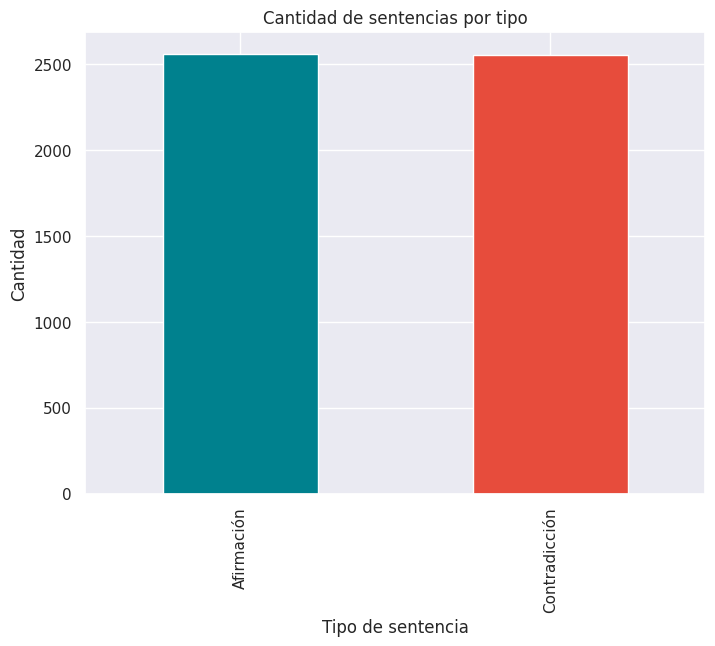

In [39]:
sns.set(style='darkgrid')
colores = ['#00818E', '#e74c3c']
counts = df['gold_label'].value_counts().rename({0: 'Afirmación', 1: 'Contradicción'})

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color = colores)
plt.title('Cantidad de sentencias por tipo')
plt.xlabel('Tipo de sentencia')
plt.ylabel('Cantidad')
plt.show()

In [40]:
#@title Limpieza de datos

def limpiarTexto(texto):
  texto = str(texto).lower()
  texto = re.sub('\[.*?\]', '', texto)
  texto = re.sub('<.*?>+', '', texto)
  texto = re.sub('\n', '', texto)
  texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)
  texto = re.sub('\w*\d\w*', '', texto)
  return texto

df.head()

,sentence1,sentence2,gold_label
707,a motorcyclist does a nose wheelie.,A motorcyclist doing a wheelie,0
5638,A man in a blue shirt stands with his hands on...,The man is standing upright.,0
709,A man sitting on a scooter on the curb.,"A man is outside, near the street.",0
2915,A woman who has just finished her dance perfor...,A woman just finished dancing.,0
2348,Repairing a house in the hot sun how unfunny t...,It is to warm to be outside.,0


In [41]:
df['sentence1'] = df['sentence1'].apply(limpiarTexto)
df['sentence2'] = df['sentence2'].apply(limpiarTexto)
df.head()

,sentence1,sentence2,gold_label
707,a motorcyclist does a nose wheelie,a motorcyclist doing a wheelie,0
5638,a man in a blue shirt stands with his hands on...,the man is standing upright,0
709,a man sitting on a scooter on the curb,a man is outside near the street,0
2915,a woman who has just finished her dance,a woman just finished dancing,0
2348,repairing a house in the hot sun how unfunny t...,it is to warm to be outside,0


In [42]:
#@title Pre procesamiento
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
  
df['sentence1'] = df['sentence1'].apply(remove_stopwords)
df['sentence2'] = df['sentence2'].apply(remove_stopwords)
df['sentence1'].shape
df['sentence2'].shape


(5113,)

In [43]:
stemmer = nltk.SnowballStemmer('english')
def stematizar(texto):
  texto = ' '.join(stemmer.stem(word) for word in texto.split(' ')) #Divide el texto, y aplica la función de stematización a cada palabra
  return texto
df['sentence1'] = df['sentence1'].apply(stematizar)
df['sentence2'] = df['sentence2'].apply(stematizar)
df.head()


,sentence1,sentence2,gold_label
707,motorcyclist nose wheeli,motorcyclist wheeli,0
5638,man blue shirt stand hand hip,man stand upright,0
709,man sit scooter curb,man outsid near street,0
2915,woman finish danc,woman finish danc,0
2348,repair hous hot sun unfunni,warm outsid,0


In [44]:
df['sentence1'].shape
df['sentence2'].shape

(5113,)

In [45]:
#@title Tokenización
sentencias_arreglo = np.asarray([df['sentence1'],df['sentence2']])
print(sentencias_arreglo)
sentencias_arreglo = sentencias_arreglo.reshape(-1,1)

[['motorcyclist nose wheeli' 'man blue shirt stand hand hip'
  'man sit scooter curb' ... 'femal street entertain horn curtsey'
  'man wear gray sweater walk pile leav'
  'woman blue dress sing bandmat play instrument']
 ['motorcyclist wheeli' 'man stand upright' 'man outsid near street' ...
  'woman street' 'man take drive test' 'peopl sing play instrument']]


In [46]:
print(sentencias_arreglo)

[['motorcyclist nose wheeli']
 ['man blue shirt stand hand hip']
 ['man sit scooter curb']
 ...
 ['woman street']
 ['man take drive test']
 ['peopl sing play instrument']]


In [47]:
sentencias_arreglo = sentencias_arreglo.reshape(sentencias_arreglo.shape[0])
print(sentencias_arreglo)

['motorcyclist nose wheeli' 'man blue shirt stand hand hip'
 'man sit scooter curb' ... 'woman street' 'man take drive test'
 'peopl sing play instrument']


In [48]:
tokenizar = Tokenizer(num_words = 6000)
tokenizar.fit_on_texts(sentencias_arreglo) #Transforma a "número" las palabras dentro del arreglo

In [49]:
texto_original_seq = tokenizar.texts_to_sequences(df['sentence1']) #Guarda un arreglo que en vez de palabras, posee índices de palabras
texto_original = pad_sequences(texto_original_seq) #Agrega padding para estandarizar el tamaño
hipotesis_seq = tokenizar.texts_to_sequences(df['sentence2'])
hipotesis = pad_sequences(hipotesis_seq, maxlen = texto_original.shape[1])
print(hipotesis)

[[   0    0    0 ...    0  198  523]
 [   0    0    0 ...    1    7 2156]
 [   0    0    0 ...   23   54   25]
 ...
 [   0    0    0 ...    0    2   25]
 [   0    0    0 ...   64  222 1432]
 [   0    0    0 ...  147    5  165]]


In [50]:
encoder = LabelEncoder()
etiquetas = df['gold_label']
etiquetas = encoder.fit_transform(etiquetas)
etiquetas

array([0, 0, 0, ..., 0, 1, 0])

In [51]:
etiquetas = to_categorical(etiquetas)
etiquetas

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [52]:
texto_original.shape

(5113, 28)

In [53]:
hipotesis.shape

(5113, 28)

In [54]:
data_tokenizada = np.asarray([texto_original,hipotesis])
data_tokenizada

array([[[   0,    0,    0, ...,  198,  928,  523],
        [   0,    0,    0, ...,    7,   55, 1440],
        [   0,    0,    0, ...,    9,  480,  756],
        ...,
        [   0,    0,    0, ...,  984, 2004, 2005],
        [   0,    0,    0, ...,   13,  428,  617],
        [   0,    0,    0, ..., 1952,    5,  165]],

       [[   0,    0,    0, ...,    0,  198,  523],
        [   0,    0,    0, ...,    1,    7, 2156],
        [   0,    0,    0, ...,   23,   54,   25],
        ...,
        [   0,    0,    0, ...,    0,    2,   25],
        [   0,    0,    0, ...,   64,  222, 1432],
        [   0,    0,    0, ...,  147,    5,  165]]], dtype=int32)

In [56]:
#@title Embedding
vocabulario = tokenizar.word_index

def gloveWork(archivo,vocabulario):
  embeddings_index = {}
  file_ = open(archivo)
  for line in file_:
      arr = line.split()
      palabra = arr[0]
      vector = np.asarray(arr[1:],dtype='float32')
      embeddings_index[palabra] = vector
  file_.close()
  tam_maximo = vocabulario + 1
  indices_palabras = tokenizar.word_index
  embedding_matriz = np.zeros((tam_maximo,300)).astype(object)
  


3007
